In [80]:
import numpy as np
import pywt
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import scale
from scipy.stats import pearsonr
from statsmodels.tsa.stattools import grangercausalitytests

In [133]:
df = pd.read_csv('WeatherDataset_ACCESS.csv').iloc[:,1:-1]
df.head()

,Day,Min,Max,Rain
0,1,-8.9,7.4,0.0
1,2,-0.8,1.2,0.0
2,3,2.8,4.8,0.0
3,4,-10.8,2.9,0.0
4,5,-2.9,6.6,9.4


In [151]:
df.shape

(36500, 4)

In [134]:
def wavelet_approximation(ts, wavelet='db1', level=1):
    coeffs = pywt.wavedec(ts, wavelet, level=level)
    return coeffs[0]

# 计算时间序列的内积
def compute_inner_product(ts1, ts2, window_size):
    inner_products = []
    for i in range(0, len(ts1) - window_size + 1, window_size):
        window_ts1 = ts1[i:i + window_size]
        window_ts2 = ts2[i:i + window_size]
        inner_product = np.dot(window_ts1, window_ts2)
        inner_products.append(inner_product)
    return np.array(inner_products)

# 分割时间序列
def segment_time_series(inner_products):
    segments = []
    current_segment = []
    current_sign = np.sign(inner_products[0])
    
    for i, ip in enumerate(inner_products):
        sign = np.sign(ip)
        if sign == current_sign:
            current_segment.append(i)
        else:
            segments.append(current_segment)
            current_segment = [i]
            current_sign = sign
    
    if current_segment:
        segments.append(current_segment)
    
    # 将最后一个区间的最后一位数扩展到时间序列的总长度
    if segments[-1][-1] < len(inner_products) - 1:
        segments[-1].append(len(inner_products) - 1)
    
    return segments

# 示例代码
wavelet = 'db1'
level = 0
window_size = 1

# 假设 df 是你的数据框架，这里使用示例数据
#df = pd.DataFrame(np.random.randn(36500, 4))

# 小波变换提取近似分量
approx_ts1 = wavelet_approximation(scale(df.values[:, 0]), wavelet, level)
approx_ts2 = wavelet_approximation(scale(df.values[:, 1]), wavelet, level)

# 计算内积
inner_products = compute_inner_product(approx_ts1, approx_ts2, window_size)

# 分割时间序列
segments = segment_time_series(inner_products)

print(segments[-1])  # 输出最后一个区间的索引范围


[36497, 36498, 36499]


In [135]:
print(inner_products)

[ 5.01381792  2.34717727  1.16775985 ... -1.07055572 -2.2820145
 -0.9841666 ]


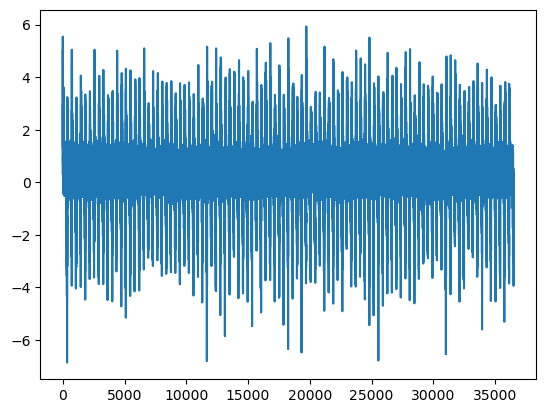

In [136]:
plt.plot(inner_products)

In [137]:
df.shape

(36500, 4)

In [138]:
segments = segment_time_series(inner_products)
print(segments[-1])

[36497, 36498, 36499]


In [139]:
segments[-1]

[36497, 36498, 36499]

In [140]:
def calculate_pearson(x, y):
    return pearsonr(x, y)[0]

# 定义计算因果关系的函数
def calculate_granger_causality(x, y, max_lag=0):
    # 确保输入数据的形状正确
    if len(x) != len(y):
        raise ValueError("Input time series must have the same length")
    
    # 格兰杰因果检验
    data = np.column_stack([x, y])
    test_result = grangercausalitytests(data, max_lag, verbose=False)
    
    # 提取p-value最小的结果
    p_values = [test[0]['ssr_chi2test'][1] for test in test_result.values()]
    min_p_value = min(p_values)
    
    # 如果p-value小于0.05，我们认为存在因果关系
    return 1 if min_p_value < 0.05 else 0

# 定义计算伪相关系数的函数
def calculate_spurious_correlation(x, y, max_lag=0):
    pcc = calculate_pearson(x, y)
    causality = calculate_granger_causality(x, y, max_lag)
    if causality == 0:
        return 1
    else:
        return causality - abs(pcc)


In [141]:
np.corrcoef(df.T.values).shape

(4, 4)

In [142]:
a = [25]
a.insert(0,1)
a

[1, 25]

In [143]:
def merge_segments(segment):
    final_segment = []
    for i in range(len(segment)):
        if len(segment[i]) != 1:
            final_segment.append(segment[i])
        else:
            if i == 0:
                # 如果是第一个元素并且是单点，则与后面的区间合并
                segment[i+1].insert(0, segment[i][0])
            elif i == len(segment) - 1:
                # 如果是最后一个元素并且是单点，则与前面的区间合并
                final_segment[-1].append(segment[i][0])
            else:
                # 否则与前面的区间合并
                final_segment[-1].append(segment[i][0])
    return final_segment

In [144]:
final = merge_segments(segments)

In [146]:
final[3]

[44, 45, 46]

In [147]:
Corr_Matrix = []
for i in final_segments[0]:
    Corr_Matrix.append(np.corrcoef(scale(df.values[i[0]:i[-1],:].T)))
    print(i)
Corr_Matrix = np.array(Corr_Matrix)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[28, 29]
[28, 29]
[30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42]
[42, 43]
[44, 45]
[45, 46]
[47, 48, 49]
[49, 50]
[51, 52, 53]
[53, 54]
[55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82]
[82, 83]
[83, 84]
[84, 85]
[86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101]
[101, 102]
[103, 104, 105, 106, 107, 108, 109, 110]
[110, 111]
[112, 113, 114, 115]
[115, 116]
[117, 118, 119, 120]
[121, 122]
[123, 124, 125]
[125, 126]
[127, 128]
[129, 130, 131, 132, 133, 134]
[134, 135]
[136, 137, 138, 139, 140, 141]
[142, 143, 144, 145]
[146, 147]
[147, 148]
[148, 149]
[149, 150]
[151, 152, 153, 154, 155]
[155, 156]
[157, 158, 159]
[159, 160]
[160, 161]
[161, 162]
[163, 164]
[164, 165]
[166, 167, 168, 169]
[170, 171, 172]
[173, 174, 175, 176, 177, 178, 179, 180, 181]
[181, 182]
[183, 184, 185, 186, 187, 188, 189, 190, 19

d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for sli

[1209, 1210, 1211, 1212, 1213]
[1213, 1214]
[1214, 1215]
[1216, 1217]
[1217, 1218]
[1219, 1220]
[1220, 1221]
[1222, 1223, 1224, 1225]
[1225, 1226]
[1227, 1228, 1229, 1230, 1231, 1232]
[1233, 1234, 1235]
[1236, 1237, 1238, 1239, 1240, 1241, 1242, 1243, 1244, 1245, 1246, 1247, 1248]
[1248, 1249]
[1250, 1251, 1252]
[1253, 1254, 1255]
[1256, 1257, 1258, 1259, 1260, 1261, 1262]
[1262, 1263]
[1264, 1265, 1266, 1267, 1268, 1269, 1270, 1271, 1272, 1273, 1274, 1275, 1276]
[1276, 1277]
[1278, 1279, 1280, 1281, 1282, 1283, 1284, 1285, 1286, 1287, 1288, 1289, 1290, 1291, 1292, 1293, 1294, 1295, 1296, 1297, 1298, 1299, 1300, 1301, 1302, 1303, 1304, 1305, 1306, 1307, 1308, 1309, 1310, 1311, 1312, 1313, 1314, 1315, 1316, 1317, 1318, 1319, 1320, 1321, 1322, 1323, 1324, 1325, 1326, 1327, 1328, 1329, 1330, 1331, 1332, 1333, 1334, 1335, 1336, 1337, 1338, 1339, 1340, 1341, 1342, 1343, 1344, 1345, 1346]
[1346, 1347]
[1348, 1349, 1350, 1351, 1352, 1353, 1354, 1355, 1356, 1357, 1358, 1359, 1360, 1361, 1362, 

d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for sli

[2517, 2518]
[2519, 2520]
[2520, 2521]
[2522, 2523, 2524]
[2524, 2525]
[2526, 2527, 2528, 2529, 2530, 2531, 2532, 2533, 2534, 2535, 2536, 2537]
[2537, 2538]
[2539, 2540, 2541, 2542, 2543, 2544, 2545, 2546, 2547, 2548, 2549, 2550, 2551, 2552]
[2552, 2553]
[2553, 2554]
[2555, 2556, 2557, 2558, 2559, 2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572]
[2572, 2573]
[2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2598, 2599, 2600, 2601, 2602, 2603, 2604, 2605, 2606, 2607, 2608, 2609, 2610, 2611, 2612, 2613, 2614, 2615, 2616, 2617, 2618, 2619, 2620, 2621, 2622, 2623, 2624]
[2624, 2625]
[2625, 2626]
[2626, 2627]
[2628, 2629, 2630, 2631, 2632]
[2632, 2633]
[2634, 2635, 2636, 2637]
[2637, 2638]
[2639, 2640, 2641, 2642, 2643, 2644, 2645, 2646]
[2646, 2647]
[2648, 2649, 2650, 2651, 2652, 2653, 2654, 2655, 2656, 2657]
[2657, 2658]
[2659, 2660, 2661, 2662, 2663, 2664, 2665, 266

d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for sli

[3759, 3760, 3761, 3762]
[3762, 3763]
[3763, 3764]
[3765, 3766]
[3767, 3768]
[3769, 3770]
[3771, 3772, 3773]
[3773, 3774]
[3774, 3775]
[3776, 3777, 3778]
[3778, 3779]
[3779, 3780]
[3781, 3782, 3783]
[3784, 3785, 3786, 3787]
[3787, 3788]
[3788, 3789]
[3790, 3791]
[3792, 3793, 3794, 3795]
[3795, 3796]
[3797, 3798]
[3799, 3800]
[3801, 3802, 3803, 3804, 3805, 3806, 3807, 3808, 3809, 3810, 3811, 3812, 3813, 3814, 3815, 3816, 3817, 3818, 3819]
[3819, 3820]
[3821, 3822]
[3822, 3823]
[3824, 3825, 3826, 3827, 3828]
[3828, 3829]
[3830, 3831]
[3831, 3832]
[3833, 3834, 3835, 3836, 3837, 3838, 3839, 3840, 3841, 3842, 3843, 3844, 3845, 3846, 3847, 3848, 3849, 3850, 3851, 3852, 3853, 3854, 3855, 3856, 3857, 3858, 3859, 3860, 3861, 3862, 3863, 3864, 3865, 3866, 3867, 3868, 3869, 3870, 3871, 3872, 3873, 3874, 3875, 3876, 3877, 3878, 3879, 3880, 3881, 3882, 3883, 3884, 3885, 3886, 3887, 3888, 3889, 3890, 3891, 3892, 3893, 3894, 3895, 3896, 3897, 3898, 3899, 3900, 3901, 3902, 3903, 3904]
[3904, 3905]
[39

d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for sli

[5014, 5015]
[5016, 5017]
[5018, 5019]
[5020, 5021, 5022, 5023]
[5023, 5024]
[5025, 5026]
[5026, 5027]
[5028, 5029, 5030]
[5031, 5032]
[5033, 5034]
[5034, 5035]
[5035, 5036]
[5036, 5037]
[5037, 5038]
[5038, 5039]
[5039, 5040]
[5041, 5042]
[5042, 5043]
[5044, 5045, 5046, 5047, 5048, 5049, 5050]
[5050, 5051]
[5051, 5052]
[5052, 5053]
[5053, 5054]
[5054, 5055]
[5055, 5056]
[5056, 5057]
[5058, 5059, 5060]
[5060, 5061]
[5062, 5063]
[5063, 5064]
[5065, 5066, 5067, 5068, 5069, 5070, 5071, 5072, 5073, 5074, 5075, 5076, 5077, 5078, 5079]
[5079, 5080]
[5081, 5082, 5083, 5084, 5085, 5086, 5087, 5088, 5089, 5090, 5091]
[5091, 5092]
[5093, 5094, 5095, 5096, 5097, 5098, 5099, 5100, 5101, 5102, 5103, 5104, 5105, 5106, 5107, 5108, 5109]
[5110, 5111, 5112, 5113, 5114, 5115, 5116, 5117, 5118, 5119, 5120, 5121, 5122, 5123, 5124, 5125, 5126, 5127, 5128, 5129]
[5129, 5130]
[5131, 5132, 5133, 5134, 5135, 5136, 5137, 5138, 5139, 5140, 5141, 5142, 5143, 5144, 5145, 5146, 5147, 5148, 5149, 5150, 5151, 5152, 51

d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for sli

[5982, 5983]
[5983, 5984]
[5985, 5986, 5987, 5988]
[5989, 5990, 5991]
[5991, 5992]
[5992, 5993]
[5994, 5995]
[5995, 5996]
[5997, 5998, 5999, 6000, 6001, 6002, 6003, 6004, 6005, 6006]
[6006, 6007]
[6008, 6009, 6010, 6011, 6012, 6013, 6014, 6015, 6016, 6017, 6018, 6019, 6020, 6021]
[6021, 6022]
[6023, 6024, 6025, 6026, 6027, 6028]
[6028, 6029]
[6030, 6031, 6032, 6033, 6034, 6035, 6036, 6037, 6038, 6039, 6040, 6041, 6042, 6043, 6044, 6045, 6046, 6047, 6048, 6049, 6050, 6051, 6052, 6053, 6054, 6055, 6056, 6057, 6058, 6059, 6060, 6061, 6062, 6063, 6064, 6065, 6066, 6067, 6068, 6069, 6070, 6071, 6072, 6073, 6074, 6075, 6076, 6077, 6078, 6079, 6080, 6081, 6082, 6083, 6084, 6085, 6086, 6087, 6088, 6089, 6090, 6091, 6092, 6093, 6094, 6095, 6096, 6097, 6098, 6099, 6100, 6101]
[6101, 6102]
[6103, 6104]
[6104, 6105]
[6106, 6107, 6108, 6109, 6110, 6111, 6112]
[6112, 6113]
[6114, 6115, 6116, 6117, 6118, 6119, 6120, 6121, 6122]
[6123, 6124, 6125]
[6125, 6126]
[6126, 6127]
[6128, 6129]
[6129, 6130]
[6

d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for sli

[7269, 7270]
[7271, 7272, 7273, 7274]
[7274, 7275]
[7276, 7277, 7278, 7279, 7280, 7281, 7282, 7283, 7284, 7285, 7286, 7287, 7288, 7289]
[7289, 7290]
[7291, 7292, 7293, 7294, 7295, 7296, 7297, 7298, 7299]
[7300, 7301, 7302, 7303, 7304, 7305, 7306, 7307, 7308, 7309, 7310, 7311, 7312, 7313, 7314, 7315, 7316, 7317, 7318, 7319, 7320, 7321, 7322, 7323, 7324, 7325, 7326, 7327, 7328, 7329, 7330, 7331, 7332, 7333, 7334, 7335, 7336, 7337, 7338, 7339, 7340, 7341, 7342, 7343, 7344, 7345]
[7345, 7346]
[7347, 7348]
[7348, 7349]
[7350, 7351, 7352, 7353, 7354, 7355, 7356, 7357, 7358, 7359, 7360, 7361, 7362, 7363, 7364, 7365, 7366, 7367, 7368, 7369, 7370, 7371, 7372, 7373, 7374, 7375]
[7375, 7376]
[7376, 7377]
[7377, 7378]
[7379, 7380, 7381]
[7381, 7382]
[7383, 7384, 7385, 7386]
[7386, 7387]
[7388, 7389, 7390]
[7390, 7391]
[7392, 7393, 7394]
[7394, 7395]
[7396, 7397, 7398]
[7398, 7399]
[7399, 7400]
[7401, 7402]
[7402, 7403]
[7404, 7405]
[7406, 7407, 7408, 7409, 7410, 7411, 7412, 7413, 7414, 7415]
[7415

d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for sli

[9784, 9785]
[9785, 9786]
[9786, 9787]
[9788, 9789]
[9790, 9791]
[9791, 9792]
[9793, 9794, 9795]
[9796, 9797]
[9797, 9798]
[9798, 9799]
[9799, 9800]
[9800, 9801]
[9802, 9803, 9804, 9805]
[9805, 9806]
[9807, 9808, 9809, 9810]
[9811, 9812]
[9813, 9814]
[9815, 9816]
[9816, 9817]
[9817, 9818]
[9819, 9820, 9821, 9822, 9823, 9824, 9825, 9826, 9827, 9828, 9829, 9830, 9831]
[9831, 9832]
[9833, 9834, 9835, 9836, 9837, 9838, 9839, 9840, 9841, 9842, 9843, 9844, 9845, 9846, 9847, 9848, 9849, 9850, 9851]
[9851, 9852]
[9853, 9854]
[9855, 9856]
[9856, 9857]
[9858, 9859, 9860, 9861, 9862, 9863, 9864, 9865, 9866, 9867, 9868]
[9868, 9869]
[9870, 9871, 9872, 9873, 9874, 9875, 9876, 9877]
[9877, 9878]
[9879, 9880, 9881, 9882]
[9883, 9884]
[9885, 9886, 9887, 9888]
[9888, 9889]
[9889, 9890]
[9890, 9891]
[9892, 9893, 9894, 9895, 9896, 9897, 9898, 9899, 9900, 9901, 9902, 9903, 9904, 9905, 9906, 9907, 9908, 9909, 9910, 9911, 9912, 9913]
[9913, 9914]
[9915, 9916, 9917, 9918, 9919, 9920, 9921, 9922, 9923, 9924, 

d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for sli

[11998, 11999, 12000, 12001, 12002, 12003, 12004, 12005, 12006, 12007, 12008, 12009, 12010, 12011, 12012, 12013, 12014]
[12015, 12016]
[12017, 12018, 12019, 12020, 12021]
[12021, 12022]
[12022, 12023]
[12023, 12024]
[12025, 12026, 12027, 12028, 12029, 12030, 12031, 12032, 12033, 12034, 12035, 12036, 12037, 12038]
[12038, 12039]
[12040, 12041, 12042, 12043, 12044]
[12045, 12046, 12047, 12048, 12049, 12050, 12051]
[12051, 12052]
[12053, 12054, 12055, 12056, 12057, 12058, 12059, 12060, 12061, 12062, 12063, 12064, 12065, 12066, 12067, 12068, 12069, 12070, 12071, 12072, 12073, 12074, 12075, 12076, 12077, 12078, 12079, 12080, 12081, 12082, 12083, 12084, 12085, 12086, 12087, 12088, 12089]
[12089, 12090]
[12091, 12092, 12093, 12094, 12095]
[12095, 12096]
[12096, 12097]
[12097, 12098]
[12099, 12100, 12101, 12102, 12103, 12104, 12105, 12106, 12107, 12108, 12109, 12110, 12111, 12112, 12113, 12114, 12115, 12116, 12117, 12118, 12119, 12120, 12121]
[12121, 12122]
[12123, 12124, 12125, 12126, 12127]


d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for sli

[13239, 13240, 13241, 13242, 13243, 13244, 13245, 13246]
[13246, 13247]
[13247, 13248]
[13248, 13249]
[13250, 13251, 13252]
[13252, 13253]
[13254, 13255, 13256, 13257, 13258, 13259, 13260]
[13261, 13262, 13263, 13264, 13265]
[13265, 13266]
[13267, 13268]
[13268, 13269]
[13269, 13270]
[13271, 13272]
[13273, 13274, 13275, 13276]
[13277, 13278, 13279]
[13279, 13280]
[13281, 13282]
[13283, 13284]
[13285, 13286]
[13287, 13288, 13289, 13290, 13291, 13292, 13293, 13294, 13295, 13296, 13297, 13298, 13299, 13300, 13301, 13302, 13303, 13304, 13305, 13306, 13307, 13308, 13309, 13310, 13311, 13312, 13313, 13314, 13315, 13316, 13317, 13318, 13319, 13320, 13321]
[13321, 13322]
[13323, 13324, 13325, 13326, 13327, 13328, 13329, 13330, 13331, 13332, 13333, 13334, 13335, 13336, 13337, 13338, 13339, 13340, 13341, 13342, 13343, 13344, 13345, 13346, 13347, 13348, 13349, 13350, 13351, 13352, 13353, 13354, 13355, 13356, 13357, 13358, 13359, 13360, 13361, 13362, 13363, 13364, 13365, 13366, 13367, 13368, 13369

d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for sli

[14550, 14551, 14552, 14553, 14554, 14555]
[14555, 14556]
[14557, 14558]
[14559, 14560]
[14560, 14561]
[14561, 14562]
[14563, 14564, 14565, 14566, 14567, 14568, 14569]
[14569, 14570]
[14571, 14572, 14573, 14574, 14575, 14576, 14577]
[14577, 14578]
[14579, 14580, 14581, 14582, 14583, 14584, 14585, 14586, 14587, 14588, 14589, 14590, 14591, 14592, 14593, 14594, 14595, 14596, 14597]
[14597, 14598]
[14598, 14599]
[14600, 14601, 14602, 14603, 14604, 14605, 14606, 14607, 14608, 14609, 14610, 14611, 14612, 14613, 14614, 14615]
[14615, 14616]
[14617, 14618, 14619, 14620, 14621, 14622, 14623, 14624, 14625, 14626, 14627]
[14627, 14628]
[14629, 14630, 14631, 14632]
[14632, 14633]
[14634, 14635, 14636, 14637, 14638, 14639, 14640, 14641, 14642, 14643]
[14643, 14644]
[14645, 14646, 14647, 14648, 14649, 14650, 14651, 14652, 14653, 14654, 14655, 14656, 14657, 14658, 14659, 14660, 14661, 14662, 14663, 14664, 14665, 14666, 14667, 14668, 14669, 14670, 14671, 14672]
[14672, 14673]
[14674, 14675, 14676]
[14

d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for sli

[15847, 15848, 15849, 15850]
[15850, 15851]
[15852, 15853, 15854, 15855, 15856, 15857, 15858, 15859, 15860, 15861, 15862, 15863, 15864, 15865]
[15865, 15866]
[15867, 15868, 15869, 15870, 15871]
[15871, 15872]
[15873, 15874, 15875, 15876]
[15876, 15877]
[15878, 15879, 15880, 15881, 15882, 15883, 15884, 15885, 15886, 15887, 15888, 15889, 15890, 15891, 15892, 15893, 15894, 15895, 15896, 15897, 15898, 15899, 15900, 15901, 15902, 15903, 15904, 15905, 15906, 15907, 15908, 15909, 15910, 15911, 15912, 15913, 15914, 15915, 15916, 15917, 15918, 15919, 15920, 15921, 15922, 15923, 15924, 15925, 15926, 15927, 15928, 15929, 15930, 15931, 15932, 15933, 15934, 15935, 15936, 15937, 15938, 15939, 15940, 15941, 15942, 15943, 15944, 15945, 15946, 15947, 15948, 15949, 15950, 15951, 15952, 15953, 15954, 15955, 15956, 15957, 15958, 15959, 15960, 15961, 15962, 15963, 15964, 15965, 15966]
[15966, 15967]
[15968, 15969, 15970, 15971, 15972, 15973, 15974, 15975, 15976, 15977, 15978, 15979]
[15980, 15981, 15982]
[

d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for sli

[17093, 17094]
[17094, 17095]
[17096, 17097, 17098]
[17098, 17099]
[17100, 17101, 17102]
[17103, 17104]
[17105, 17106, 17107, 17108]
[17109, 17110]
[17111, 17112, 17113, 17114, 17115, 17116]
[17117, 17118]
[17118, 17119]
[17120, 17121]
[17122, 17123, 17124, 17125]
[17125, 17126]
[17127, 17128, 17129, 17130, 17131, 17132, 17133, 17134]
[17134, 17135]
[17136, 17137, 17138, 17139, 17140, 17141, 17142, 17143, 17144, 17145, 17146, 17147, 17148, 17149, 17150, 17151, 17152, 17153, 17154]
[17155, 17156, 17157, 17158, 17159, 17160, 17161]
[17162, 17163]
[17164, 17165, 17166, 17167, 17168, 17169, 17170, 17171, 17172, 17173, 17174, 17175]
[17175, 17176]
[17177, 17178]
[17178, 17179]
[17180, 17181, 17182]
[17182, 17183]
[17184, 17185, 17186, 17187, 17188, 17189, 17190, 17191, 17192, 17193, 17194, 17195, 17196, 17197, 17198, 17199, 17200, 17201, 17202, 17203, 17204, 17205, 17206, 17207, 17208, 17209, 17210, 17211, 17212, 17213, 17214, 17215]
[17216, 17217]
[17218, 17219, 17220]
[17220, 17221]
[1722

d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for sli

[18394, 18395]
[18396, 18397]
[18398, 18399, 18400]
[18401, 18402, 18403, 18404, 18405, 18406, 18407, 18408, 18409]
[18409, 18410]
[18411, 18412, 18413, 18414, 18415, 18416, 18417, 18418, 18419, 18420, 18421, 18422]
[18422, 18423]
[18424, 18425]
[18425, 18426]
[18427, 18428, 18429, 18430, 18431]
[18431, 18432]
[18433, 18434, 18435, 18436, 18437, 18438, 18439, 18440, 18441, 18442, 18443, 18444, 18445, 18446, 18447, 18448, 18449, 18450, 18451, 18452, 18453, 18454, 18455, 18456, 18457, 18458, 18459, 18460, 18461, 18462, 18463, 18464, 18465, 18466, 18467, 18468, 18469, 18470, 18471, 18472, 18473, 18474, 18475, 18476, 18477, 18478, 18479, 18480, 18481, 18482, 18483, 18484, 18485, 18486, 18487, 18488, 18489, 18490, 18491, 18492, 18493, 18494, 18495, 18496, 18497, 18498, 18499, 18500, 18501, 18502, 18503, 18504, 18505, 18506, 18507, 18508, 18509, 18510, 18511, 18512, 18513, 18514, 18515, 18516, 18517, 18518, 18519, 18520, 18521, 18522]
[18522, 18523]
[18524, 18525, 18526, 18527]
[18527, 18528

d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for sli

[20934, 20935]
[20936, 20937]
[20938, 20939, 20940, 20941, 20942, 20943, 20944]
[20944, 20945]
[20945, 20946]
[20946, 20947]
[20948, 20949, 20950]
[20950, 20951]
[20952, 20953, 20954, 20955, 20956, 20957, 20958, 20959, 20960, 20961, 20962, 20963, 20964, 20965, 20966, 20967]
[20967, 20968]
[20969, 20970, 20971]
[20971, 20972]
[20973, 20974, 20975, 20976, 20977, 20978, 20979, 20980, 20981, 20982, 20983, 20984, 20985, 20986]
[20986, 20987]
[20988, 20989, 20990, 20991, 20992, 20993, 20994, 20995, 20996, 20997, 20998, 20999, 21000, 21001, 21002, 21003, 21004, 21005, 21006, 21007, 21008, 21009, 21010]
[21010, 21011]
[21012, 21013, 21014, 21015, 21016, 21017, 21018, 21019, 21020, 21021, 21022, 21023, 21024, 21025, 21026, 21027, 21028, 21029, 21030, 21031, 21032, 21033, 21034, 21035, 21036, 21037, 21038, 21039, 21040, 21041, 21042, 21043, 21044, 21045, 21046, 21047, 21048, 21049, 21050, 21051, 21052, 21053, 21054, 21055, 21056, 21057, 21058, 21059, 21060, 21061, 21062, 21063, 21064, 21065, 210

d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for sli

[23438, 23439]
[23440, 23441, 23442, 23443, 23444, 23445, 23446, 23447]
[23447, 23448]
[23448, 23449]
[23449, 23450]
[23451, 23452, 23453, 23454, 23455, 23456, 23457, 23458]
[23459, 23460]
[23461, 23462, 23463, 23464, 23465, 23466]
[23466, 23467]
[23468, 23469, 23470, 23471, 23472, 23473, 23474, 23475]
[23476, 23477, 23478]
[23478, 23479]
[23480, 23481]
[23482, 23483]
[23484, 23485]
[23485, 23486]
[23486, 23487]
[23487, 23488]
[23488, 23489]
[23489, 23490]
[23491, 23492]
[23492, 23493]
[23494, 23495, 23496, 23497]
[23497, 23498]
[23498, 23499]
[23500, 23501]
[23502, 23503, 23504]
[23504, 23505]
[23506, 23507, 23508, 23509]
[23509, 23510]
[23511, 23512, 23513]
[23513, 23514]
[23514, 23515]
[23515, 23516]
[23517, 23518, 23519, 23520, 23521, 23522, 23523, 23524, 23525, 23526, 23527, 23528, 23529, 23530, 23531, 23532, 23533, 23534, 23535, 23536]
[23536, 23537]
[23538, 23539, 23540, 23541]
[23541, 23542]
[23543, 23544, 23545, 23546, 23547, 23548, 23549, 23550, 23551, 23552, 23553, 23554, 23

d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for sli

[24710, 24711]
[24712, 24713, 24714, 24715, 24716, 24717, 24718, 24719]
[24719, 24720]
[24721, 24722]
[24722, 24723]
[24724, 24725, 24726, 24727, 24728, 24729, 24730, 24731, 24732]
[24732, 24733]
[24734, 24735, 24736, 24737, 24738, 24739, 24740, 24741]
[24742, 24743, 24744]
[24745, 24746, 24747, 24748]
[24748, 24749]
[24750, 24751, 24752]
[24753, 24754]
[24754, 24755]
[24755, 24756]
[24756, 24757]
[24757, 24758]
[24759, 24760, 24761, 24762, 24763]
[24763, 24764]
[24764, 24765]
[24766, 24767]
[24767, 24768]
[24769, 24770, 24771, 24772]
[24773, 24774]
[24775, 24776]
[24776, 24777]
[24778, 24779, 24780, 24781, 24782, 24783, 24784]
[24785, 24786, 24787, 24788]
[24789, 24790]
[24790, 24791]
[24792, 24793, 24794, 24795]
[24795, 24796]
[24797, 24798, 24799, 24800, 24801]
[24801, 24802]
[24803, 24804, 24805]
[24805, 24806]
[24806, 24807]
[24807, 24808]
[24808, 24809]
[24809, 24810]
[24811, 24812, 24813, 24814, 24815, 24816, 24817, 24818, 24819]
[24820, 24821, 24822, 24823]
[24823, 24824]
[2482

d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for sli

[25937, 25938]
[25939, 25940, 25941, 25942, 25943, 25944, 25945, 25946, 25947, 25948, 25949]
[25949, 25950]
[25951, 25952, 25953, 25954, 25955, 25956, 25957, 25958, 25959, 25960, 25961, 25962, 25963, 25964, 25965, 25966, 25967, 25968, 25969, 25970, 25971, 25972, 25973, 25974, 25975, 25976, 25977, 25978, 25979, 25980, 25981, 25982, 25983, 25984, 25985, 25986, 25987, 25988, 25989, 25990, 25991, 25992, 25993, 25994, 25995, 25996, 25997, 25998, 25999, 26000]
[26000, 26001]
[26001, 26002]
[26003, 26004, 26005]
[26006, 26007]
[26008, 26009]
[26010, 26011]
[26011, 26012]
[26012, 26013]
[26013, 26014]
[26015, 26016, 26017, 26018, 26019, 26020, 26021, 26022]
[26023, 26024, 26025]
[26026, 26027, 26028, 26029, 26030, 26031, 26032, 26033, 26034, 26035, 26036]
[26036, 26037]
[26037, 26038]
[26039, 26040]
[26040, 26041]
[26042, 26043, 26044]
[26045, 26046]
[26047, 26048]
[26048, 26049]
[26050, 26051]
[26051, 26052]
[26053, 26054, 26055, 26056, 26057, 26058]
[26058, 26059]
[26059, 26060]
[26061, 2606

d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for sli

[28531, 28532, 28533, 28534, 28535, 28536, 28537]
[28537, 28538]
[28539, 28540, 28541, 28542, 28543, 28544]
[28545, 28546]
[28547, 28548, 28549]
[28549, 28550]
[28551, 28552, 28553, 28554, 28555, 28556]
[28557, 28558]
[28559, 28560, 28561, 28562, 28563, 28564, 28565, 28566, 28567, 28568]
[28568, 28569]
[28570, 28571, 28572, 28573, 28574, 28575, 28576, 28577, 28578, 28579]
[28579, 28580]
[28581, 28582]
[28582, 28583]
[28584, 28585, 28586, 28587, 28588]
[28588, 28589]
[28590, 28591]
[28592, 28593, 28594]
[28595, 28596]
[28597, 28598]
[28598, 28599]
[28600, 28601, 28602]
[28602, 28603]
[28604, 28605]
[28605, 28606]
[28607, 28608, 28609, 28610, 28611, 28612]
[28612, 28613]
[28614, 28615, 28616, 28617, 28618, 28619, 28620, 28621]
[28621, 28622]
[28623, 28624]
[28624, 28625]
[28626, 28627]
[28627, 28628]
[28629, 28630, 28631, 28632, 28633, 28634, 28635]
[28635, 28636]
[28637, 28638, 28639, 28640, 28641, 28642, 28643, 28644, 28645, 28646, 28647, 28648, 28649, 28650, 28651]
[28651, 28652]
[286

d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for sli

[29570, 29571, 29572, 29573, 29574, 29575, 29576, 29577, 29578, 29579, 29580, 29581, 29582]
[29582, 29583]
[29584, 29585, 29586, 29587, 29588, 29589, 29590, 29591, 29592, 29593, 29594, 29595, 29596, 29597, 29598, 29599, 29600, 29601, 29602, 29603, 29604, 29605, 29606]
[29606, 29607]
[29607, 29608]
[29608, 29609]
[29609, 29610]
[29610, 29611]
[29612, 29613, 29614, 29615, 29616]
[29616, 29617]
[29618, 29619, 29620, 29621, 29622, 29623, 29624]
[29625, 29626]
[29627, 29628, 29629, 29630, 29631, 29632, 29633, 29634]
[29634, 29635]
[29636, 29637, 29638, 29639, 29640, 29641, 29642, 29643, 29644, 29645]
[29645, 29646]
[29646, 29647]
[29648, 29649, 29650]
[29650, 29651]
[29652, 29653]
[29654, 29655, 29656, 29657, 29658, 29659, 29660]
[29660, 29661]
[29661, 29662]
[29662, 29663]
[29664, 29665, 29666, 29667, 29668, 29669, 29670, 29671]
[29671, 29672]
[29673, 29674, 29675]
[29675, 29676]
[29677, 29678, 29679, 29680]
[29680, 29681]
[29681, 29682]
[29682, 29683]
[29684, 29685]
[29686, 29687, 29688, 

d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for sli

[30722, 30723]
[30723, 30724]
[30725, 30726, 30727, 30728]
[30728, 30729]
[30730, 30731]
[30731, 30732]
[30733, 30734]
[30735, 30736]
[30736, 30737]
[30737, 30738]
[30739, 30740, 30741, 30742, 30743, 30744, 30745, 30746, 30747, 30748, 30749, 30750, 30751, 30752, 30753, 30754]
[30754, 30755]
[30756, 30757, 30758]
[30758, 30759]
[30760, 30761]
[30761, 30762]
[30762, 30763]
[30764, 30765]
[30766, 30767, 30768]
[30768, 30769]
[30770, 30771, 30772, 30773, 30774, 30775]
[30775, 30776]
[30777, 30778, 30779, 30780, 30781]
[30781, 30782]
[30782, 30783]
[30784, 30785]
[30786, 30787]
[30788, 30789]
[30790, 30791]
[30792, 30793, 30794, 30795, 30796, 30797, 30798, 30799, 30800, 30801]
[30801, 30802]
[30803, 30804, 30805]
[30805, 30806]
[30807, 30808]
[30808, 30809]
[30810, 30811, 30812]
[30812, 30813]
[30814, 30815, 30816, 30817, 30818, 30819, 30820, 30821, 30822, 30823, 30824, 30825, 30826, 30827, 30828, 30829, 30830, 30831, 30832, 30833, 30834, 30835, 30836, 30837, 30838, 30839, 30840]
[30840, 30

d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for sli

[32836, 32837, 32838, 32839, 32840, 32841, 32842, 32843, 32844, 32845, 32846, 32847, 32848, 32849]
[32850, 32851, 32852, 32853, 32854, 32855, 32856, 32857, 32858, 32859, 32860, 32861, 32862, 32863, 32864, 32865, 32866, 32867, 32868, 32869, 32870, 32871, 32872, 32873, 32874, 32875, 32876, 32877, 32878, 32879, 32880, 32881, 32882, 32883, 32884, 32885, 32886, 32887, 32888, 32889, 32890, 32891, 32892, 32893, 32894, 32895, 32896, 32897, 32898, 32899, 32900]
[32901, 32902]
[32903, 32904, 32905, 32906, 32907]
[32907, 32908]
[32909, 32910]
[32910, 32911]
[32912, 32913, 32914, 32915]
[32915, 32916]
[32917, 32918, 32919, 32920, 32921, 32922, 32923, 32924]
[32925, 32926]
[32927, 32928, 32929, 32930, 32931]
[32931, 32932]
[32932, 32933]
[32933, 32934]
[32935, 32936, 32937, 32938]
[32938, 32939]
[32939, 32940]
[32940, 32941]
[32942, 32943, 32944, 32945, 32946, 32947, 32948, 32949, 32950, 32951, 32952, 32953, 32954, 32955, 32956, 32957, 32958, 32959]
[32960, 32961]
[32962, 32963]
[32963, 32964]
[329

d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for sli

[33981, 33982]
[33982, 33983]
[33984, 33985, 33986, 33987, 33988, 33989, 33990, 33991, 33992, 33993, 33994, 33995, 33996, 33997, 33998, 33999, 34000]
[34000, 34001]
[34002, 34003]
[34003, 34004]
[34005, 34006, 34007, 34008, 34009, 34010, 34011, 34012, 34013, 34014, 34015, 34016, 34017, 34018]
[34018, 34019]
[34020, 34021]
[34021, 34022]
[34023, 34024]
[34024, 34025]
[34026, 34027, 34028, 34029, 34030, 34031, 34032, 34033, 34034, 34035]
[34035, 34036]
[34037, 34038, 34039]
[34039, 34040]
[34041, 34042, 34043, 34044]
[34044, 34045]
[34046, 34047, 34048, 34049, 34050, 34051, 34052, 34053, 34054]
[34054, 34055]
[34055, 34056]
[34056, 34057]
[34057, 34058]
[34058, 34059]
[34059, 34060]
[34061, 34062]
[34062, 34063]
[34063, 34064]
[34064, 34065]
[34065, 34066]
[34066, 34067]
[34067, 34068]
[34068, 34069]
[34069, 34070]
[34070, 34071]
[34071, 34072]
[34072, 34073]
[34073, 34074]
[34075, 34076, 34077]
[34078, 34079]
[34079, 34080]
[34080, 34081]
[34081, 34082]
[34083, 34084, 34085]
[34086, 340

d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for sli

[35118, 35119]
[35120, 35121]
[35121, 35122]
[35122, 35123]
[35123, 35124]
[35125, 35126, 35127, 35128]
[35128, 35129]
[35130, 35131, 35132]
[35133, 35134]
[35135, 35136, 35137, 35138, 35139, 35140, 35141, 35142]
[35142, 35143]
[35144, 35145, 35146]
[35146, 35147]
[35148, 35149, 35150, 35151, 35152, 35153, 35154]
[35154, 35155]
[35156, 35157, 35158]
[35159, 35160]
[35160, 35161]
[35161, 35162]
[35163, 35164, 35165]
[35165, 35166]
[35166, 35167]
[35167, 35168]
[35169, 35170]
[35171, 35172]
[35173, 35174]
[35175, 35176, 35177, 35178, 35179]
[35179, 35180]
[35180, 35181]
[35182, 35183]
[35184, 35185, 35186]
[35186, 35187]
[35188, 35189, 35190, 35191, 35192, 35193, 35194]
[35194, 35195]
[35196, 35197, 35198, 35199, 35200, 35201, 35202, 35203, 35204]
[35204, 35205]
[35206, 35207, 35208, 35209, 35210, 35211, 35212, 35213, 35214]
[35214, 35215]
[35216, 35217, 35218, 35219, 35220, 35221]
[35221, 35222]
[35223, 35224, 35225, 35226, 35227, 35228, 35229, 35230, 35231, 35232, 35233]
[35233, 35234]

d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
d:\Anaconda\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for sli

In [148]:
Corr_Matrix.shape

(8340, 4, 4)

In [150]:
np.savetxt('Corr_Matrix.csv',Corr_Matrix.reshape(8340,-1), delimiter=',')